<a href="https://colab.research.google.com/github/saurabhmathur96/Speech-to-Text-Engine/blob/master/timit_conditioned_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install soundfile

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import zipfile

zipfile.ZipFile('My Drive/darpa-timit-acousticphonetic-continuous-speech.zip').extractall('..')

In [0]:
from pathlib import Path
import soundfile as sf 
from tqdm.auto import tqdm


def read_speech(base):
  signals = []
  targets = []
  accents = []
  sexes = []
  base = Path(base)
  for i, accent in tqdm(enumerate(base.iterdir())):
    for speaker in accent.iterdir():
      for f in speaker.iterdir():
        if f.suffix == '.wav':
          signal, rate = sf.read(f)
          signals.append(signal)

          target_file = f.name.replace('.WAV.wav', '.TXT')
          target_path = speaker / target_file
          words = open(target_path).read().strip().split(' ')[2:]
          target = ' '.join(words).lower().replace('.', '').replace(',', '').replace(' -- ', ' ').replace('-', ' ').replace('?', '').replace('"', '').replace('!', '').replace(':', '').replace(';', '')
          targets.append(target)
          accents.append(i)
          sexes.append(['M', 'F'].index(speaker.name[0]))
  return signals, targets, accents, sexes


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import numpy as np
from tqdm.auto import trange, tqdm


class SpeechData(torch.utils.data.Dataset):
  def __init__(self, inputs, input_lengths, outputs, output_lengths):
    self.inputs = inputs
    self.input_lengths = torch.Tensor(input_lengths)
    self.outputs = outputs
    self.output_lengths = torch.Tensor(output_lengths)
    
    self.n = len(inputs)
  
  def __len__(self):
    return self.n
  
  def __getitem__(self, i):
    inp = self.inputs[i]
    inp_len = self.input_lengths[i]
    op = self.outputs[i]
    op_len = self.output_lengths[i]
    return inp, inp_len, op, op_len

#
# Training data
#
s, t, accents, sexes = read_speech('../data/TRAIN')
chars = set(''.join(t))
char2index = { c: i+2 for i, c in enumerate(chars) }
char2index['<'] = 0
char2index['>'] = 1
print (char2index)

inputs = []
input_lengths =[]
outputs = []
output_lengths = []
for x, y, a, s in tqdm(zip(s, t, accents, sexes), total=len(s)):
  inp = torch.from_numpy(np.abs(librosa.stft(x, n_fft=1024, hop_length=512)).T)
  a = F.one_hot(torch.tensor([a]*len(inp)), num_classes=8).float()
  s = F.one_hot(torch.tensor([s]*len(inp)), num_classes=2).float()
  inp = torch.cat([inp, a, s], 1)
  inputs.append(inp)
  input_lengths.append(len(inp))

  output = torch.Tensor([char2index[c] for c in '<' + y + '>'])
  outputs.append(output)
  output_lengths.append(len(output)) 

train_data = SpeechData(inputs, input_lengths, outputs, output_lengths)


#
# Test data
#
s, t, accents, sexes = read_speech('../data/TEST')
inputs = []
input_lengths =[]
outputs = []
output_lengths = []
for x, y, a, s in tqdm(zip(s, t, accents, sexes), total=len(s)):
  inp = torch.from_numpy(np.abs(librosa.stft(x, n_fft=1024, hop_length=512)).T)
  a = F.one_hot(torch.tensor([a]*len(inp)), num_classes=8).float()
  s = F.one_hot(torch.tensor([s]*len(inp)), num_classes=2).float()
  inp = torch.cat([inp, a, s], 1)
  inputs.append(inp)
  input_lengths.append(len(inp))

  output = torch.Tensor([char2index[c] for c in '<' + y + '>'])
  outputs.append(output)
  output_lengths.append(len(output)) 
test_data = SpeechData(inputs, input_lengths, outputs, output_lengths)


{'m': 2, 'z': 3, 't': 4, 'f': 5, ' ': 6, 'o': 7, 'k': 8, 'p': 9, 'x': 10, 'y': 11, 'c': 12, 'r': 13, 'v': 14, 'i': 15, 'h': 16, 'g': 17, 'e': 18, 'n': 19, 'j': 20, 'd': 21, 'q': 22, 'a': 23, 's': 24, 'b': 25, 'l': 26, 'w': 27, 'u': 28, "'": 29, '<': 0, '>': 1}


In [0]:
class SpeechNet(nn.Module):
  def __init__(self, device, input_size=513, output_size=len(char2index)+1, num_layers=1, hidden_size=256):
    self.device = device
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    super(SpeechNet, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    h = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    c = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    output, (h, c) = self.lstm(x, (h,c))
    # print (h.shape, c.shape)
    out = self.linear(output)
    return torch.nn.functional.log_softmax(out, 2)
  

def collate(batch):
  inp, inp_len, op, op_len = zip(*batch)
  inp = torch.nn.utils.rnn.pad_sequence(inp, batch_first=True, padding_value=len(char2index))
  inp_len = torch.stack(inp_len)
  op = torch.cat(op) # torch.nn.utils.rnn.pad_sequence(op, batch_first=True, padding_value=len(char2index))
  op_len = torch.stack(op_len)
  return inp, inp_len, op, op_len 


import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, collate_fn=collate)

In [29]:
from torch.autograd import Variable
from tqdm.auto import tqdm
import itertools
from torch.optim.lr_scheduler import ExponentialLR

device = torch.device('cuda')

net = SpeechNet(device, input_size=523).to(device)
net.apply(weight_init)


criterion = nn.CTCLoss(blank=len(char2index), zero_infinity=True, reduction='none').to(device) 
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0.001)

scheduler = ExponentialLR(optimizer, gamma=0.9999)
losses = []
test_loss = []
for epoch in range(25):
  print (f'Epoch {epoch}:')
  for inp, inp_len, op, op_len in tqdm(train_loader):
    
    inp, inp_len = Variable(inp.float()).to(device), Variable(inp_len.long()).to(device)
    op, op_len = Variable(op.long()).to(device), Variable(op_len.long()).to(device)

    optimizer.zero_grad()
    
    p = net(inp)
    
    loss = criterion(p.transpose(0,1), op, inp_len, op_len)
    # loss[loss == float("Inf")] = 0
    # print (loss.mean())
    
    loss = loss.mean()
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 400)
    
    optimizer.step()
    scheduler.step()
  print ('train loss = ', np.mean(losses[::-1][:len(train_loader)]))
  
  
  with torch.no_grad():
    for inp, inp_len, op, op_len in tqdm(test_loader):
        
        inp, inp_len = Variable(inp.float()).to(device), Variable(inp_len.long()).to(device)
        op, op_len = Variable(op.long()).to(device), Variable(op_len.long()).to(device)
        p = net(inp)
        
        loss = criterion(p.transpose(0,1), op, inp_len, op_len)
        
        loss = loss.mean()
        test_loss.append(loss.item())
    print ('test loss = ', np.mean(test_loss[::-1][:len(test_loader)]))

    '''
    index2char = dict(zip(char2index.values(), char2index.keys()))
    for pi in p:
      for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
        if i < len(index2char):
          print (index2char[i], end = '')
      print ()
    '''

Epoch 0:


train loss =  165.54801606478756


test loss =  145.59643159089265
Epoch 1:


train loss =  141.72973110251232


test loss =  136.00545501708984
Epoch 2:


train loss =  129.6593232873368


test loss =  121.6798499778465
Epoch 3:


train loss =  116.35624287226429


test loss =  109.90504314281323
Epoch 4:


train loss =  105.86571377270842


test loss =  102.35823737250433
Epoch 5:


train loss =  97.68552973499037


test loss =  93.6382669519495
Epoch 6:


train loss =  91.61747626735739


test loss =  89.71807041874638
Epoch 7:


train loss =  86.8592379844352


test loss =  86.12067695900247
Epoch 8:


train loss =  83.50691986083984


test loss =  84.61263133861401
Epoch 9:


train loss =  81.48043175266214


test loss =  82.7274311206959
Epoch 10:


train loss =  79.09359897979319


test loss =  81.74260513870804
Epoch 11:


train loss =  77.34347278124666


test loss =  80.36506737603082
Epoch 12:


train loss =  75.54823825783926


test loss =  78.8742360715513
Epoch 13:


train loss =  74.03956891412605


test loss =  79.21996335630064
Epoch 14:


train loss =  72.44677185685667


test loss =  78.83125305175781
Epoch 15:


train loss =  71.27583433177374


test loss =  77.60093745478878
Epoch 16:


train loss =  70.0931035394538


test loss =  76.91827293678567
Epoch 17:


train loss =  68.95267821011478


test loss =  76.87766689724393
Epoch 18:


train loss =  67.99096846907106


test loss =  76.31435238873517
Epoch 19:


train loss =  66.63767017730295


test loss =  76.27843418827763
Epoch 20:


train loss =  65.5657708677527


test loss =  76.34014737164533
Epoch 21:


train loss =  65.85734720099462


test loss =  76.99300582320602
Epoch 22:


train loss =  64.40357302312981


test loss =  75.41591616030092
Epoch 23:


train loss =  62.711046924329786


test loss =  75.6336432562934
Epoch 24:


train loss =  61.87204617016936


test loss =  76.12022738986545


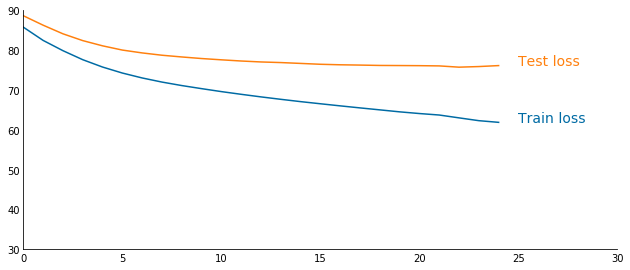

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
for i in range(len(tableau20blind)):
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)


tr = [np.mean(losses[start:start+len(losses)])  for start in range(0, len(losses), len(train_loader))]
plt.plot(tr, color=tableau20blind[0])

plt.xlim(0, len(tr)+5)
te = [np.mean(test_loss[start:start+len(test_loss)]) for start in range(0, len(test_loss), len(test_loader))]
plt.plot(te, color=tableau20blind[1])

plt.text( len(tr),tr[-1],   'Train loss', color=tableau20blind[0], fontsize=14)
plt.text( len(te),te[-1], 'Test loss', color=tableau20blind[1], fontsize=14)

plt.ylim(30, 90)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.tight_layout(pad=5)
plt.gca().tick_params(axis='both', length=0)

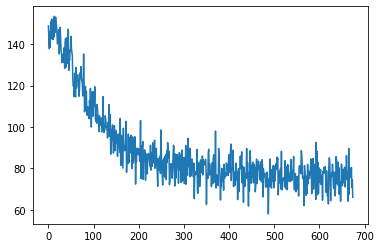

In [33]:
plt.plot(test_loss)

In [36]:
import itertools
index2char = dict(zip(char2index.values(), char2index.keys()))
with torch.no_grad():
  for inp, inp_len, op, op_len in test_loader:
      
    inp, inp_len = inp.float().to(device), inp_len.long().to(device)
    op, op_len = op.long().to(device), op_len.long().to(device)

      

    p = net(inp)
    start = 0
    for pi, o in zip(p, op_len):
      
      
      print (''.join(index2char[i] for i in op[start:start+o].cpu().numpy()))
      for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
        
        if i < len(index2char):
          print (index2char[i], end = '')
      print ('\n')
      start += o
    break

<don't ask me to carry an oily rag like that>
<don't ask me toarry anoilyrag like that>

<drop five forms in the box before you go out>
<ral tfge fan te he bocpal foree boou>

<she had your dark suit in greasy wash water all year>
<she had your dark suit in greasy wash water all year> 

<jane may earn more money by working hard>
<dean miairere mo min en mowr h mord>

<he had plunged into the dark woods beyond>
<he had plons ton to tedocpwos dhm> 

<do they make class biased decisions>
<toe ama plas by tisi ins>

<she had your dark suit in greasy wash water all year>
<she had your dark suit in greasy wash water all year> 

<the gunman kept his victim cornered at gunpoint for three hours>
<the don he catisci to cni i dompli tre treirs>

<youngsters love common candy as treats>
<don'ts hus lo conlin cae de ias tres> 

<please dig my potatoes up before frost>
<hles ta me he tains an be orfos>

<she radiated warmth and good fellowship>
<she mady eed wor hind ghithel she>

<the gallant half 